# Relaxation of 2 daughter cells after proliferation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance

dim = 3
seed = 67

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 0.0001 

params = {'EF_glob_adap_acc': {'eta': eta},
          'EF_glob_adap_stab': {'eta': eta, 'calculate_eigenvalues': True, 'write_to_file': True, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_local_adap': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True, 'local_adaptivity': True}, 
          'EB_global_adap': {'eta': eta}
         }


labels = {'EF_glob_adap_acc': 'Glob. adap. EF', 
          'EF_glob_adap_stab': 'Glob. adap. EF\n(with stab. bound)' ,  
          'EF_local_adap': 'Loc. adap. EF', 
          'EB_global_adap': 'Glob. adap. EB'
         }

## Time step sizes as a function of chosen absolute error

In [4]:
cell_list = [cl.Cell(0, [0, 0, 0]), cl.Cell(1, [0.3, 0, 0])]

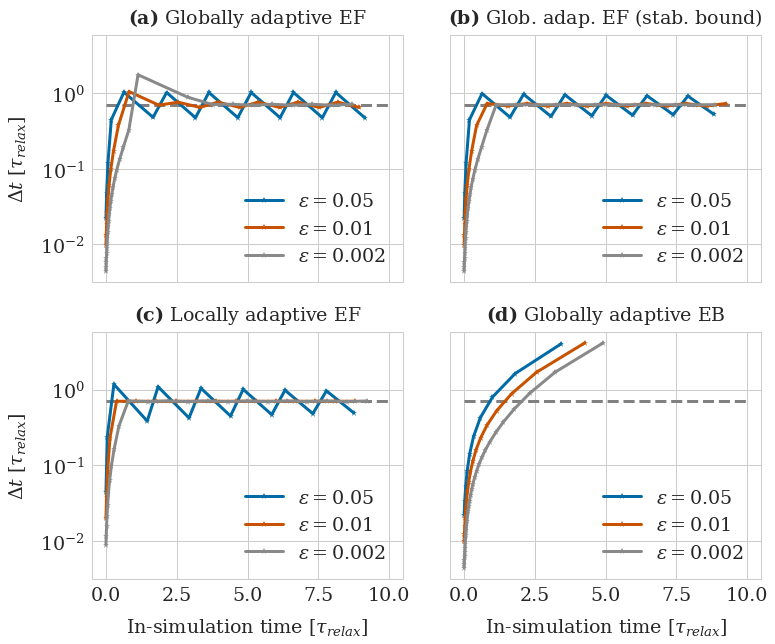

In [5]:
    
try:
    os.remove('step_sizes.txt')
except FileNotFoundError:
    print('Nothing to delete.')

colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

epsilons = [0.05, 0.01, 0.002]

gp_cubic = params_cubic['mu']*(s-rA)**2
      
for alg in algorithms:
    
    axes[alg].plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color='grey' )
    
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Globally adaptive EF')
ax2.set_title(r'$\bf{(b)}$ Glob. adap. EF (stab. bound)')
ax3.set_title(r'$\bf{(c)}$ Locally adaptive EF')
ax4.set_title(r'$\bf{(d)}$ Globally adaptive EB')
    
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax3.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')    
ax3.set(xlabel=r'In-simulation time [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time [$\tau_{relax}$]')

plt.savefig('2cells_dt.pdf', bbox_inches='tight')

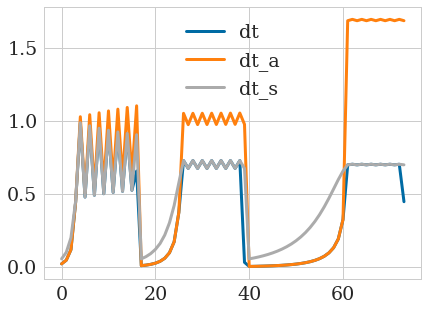

In [6]:
dts = np.loadtxt('step_sizes.txt')

plt.plot( dts[:, 0], label='dt')
plt.plot( dts[:, 1], label='dt_a')
plt.plot( dts[:, 2], label='dt_s')
plt.legend()

Note that these are the dt_s for all three epsilon values in one graph, side by side. that means the first part is for eps=0.05, once the step size restarts at 0 it's for eps=0.01 and when it restarts again it;s for eps=0.002. The problem is hence that for larger eps the calculated stability bound is less accurate and oscillates. This is independent of whether gershgorin is used or not.

## Convergence study